In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 고객 데이터 
mem = pd.read_csv("https://raw.githubusercontent.com/haram4th/ablearn/main/member.csv")

# 거래 데이터
tran = pd.read_csv("https://raw.githubusercontent.com/haram4th/ablearn/main/transaction.csv")

참고 : https://seethefuture.tistory.com/121

# 프로모션 효율 예측 (Random Forest)
분석의 목적
* Random Forest 를 이용하여, 프로모션에 반응할 고객을 예측
* 고객 데이터와 거래 데이터를 통합 활용

쇼핑몰 고객 데이터, 프로모션 쿠폰을 발행하고 사용 여부 데이터를 수집
- mem: 고객id, 최근 방문일, 사는지역, 추천여부, 주요접속채널, 쿠폰 사용 여부
- transaction: 고객id, 구매수량, 총 구매금액 정보가 있음

전통적 마케팅 분석 방법인 RFM 기법을 사용해 고객 데이터에서 파생변수 생성 후 분석
- Recency: 현재일 - 최근 구매일
- Frequency: 구매 빈도
- Monetary: 구매 금액

In [3]:
mem.head(10)

,id,recency,zip_code,is_referral,channel,conversion
0,906145,10,Surburban,0,Phone,0
1,184478,6,Rural,1,Web,0
2,394235,7,Surburban,1,Web,0
3,130152,9,Rural,1,Web,0
4,940352,2,Urban,0,Web,0
5,612635,6,Surburban,0,Phone,1
6,872298,9,Surburban,1,Phone,0
7,103308,9,Urban,0,Phone,0
8,283516,9,Rural,1,Phone,0
9,101354,10,Urban,1,Web,0


데이터 컬럼 살펴보기
* id : 아이디 (의미가 없는 컬럼으로 추후 드랍예정이다.)
* recency : 최근이용을 언제 했었나 (10일전, 6일전 ..) 
* zip_code : 우편번호 (한번 가공이 된 상태)
* is_referral : 추천인이 있고 없음 으로 가입을 했는지
* channel : 서비스 이용 채널 (폰, 웹 )
* conversion : 프로모션을 받고 나서 고객이 구입을 했는지 안했는지 (우리가 예측하고자 하는 컬럼/종속변수)

In [4]:
tran.head(20)

,id,num_item,total_amount
0,906145,5,34000
1,906145,1,27000
2,906145,4,33000
3,184478,4,29000
4,394235,4,33000
5,394235,4,8000
6,130152,2,11000
7,130152,1,22000
8,130152,1,23000
9,130152,3,27000


데이터 컬럼 살펴보기
* id : 아이디 (의미가 없는 컬럼으로 추후 드랍예정이다.)
* num_item : 한 거래에 몇개에 아이템을 구매 했는지
* total_amount : 총 금액

In [5]:
mem.info()

# mem 데이터에서는 결측치가 없음

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           64000 non-null  int64 
 1   recency      64000 non-null  int64 
 2   zip_code     64000 non-null  object
 3   is_referral  64000 non-null  int64 
 4   channel      64000 non-null  object
 5   conversion   64000 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 2.9+ MB


In [6]:
tran.info()

# tran 데이터에서는 결측치가 없음

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196836 entries, 0 to 196835
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype
---  ------        --------------   -----
 0   id            196836 non-null  int64
 1   num_item      196836 non-null  int64
 2   total_amount  196836 non-null  int64
dtypes: int64(3)
memory usage: 4.5 MB


In [7]:
mem.describe()

,id,recency,is_referral,conversion
count,64000.000000,64000.000000,64000.000000,64000.000000
mean,550694.137797,5.763734,0.502250,0.146781
std,259105.689773,3.507592,0.499999,0.353890
min,100001.000000,1.000000,0.000000,0.000000
25%,326772.000000,2.000000,0.000000,0.000000
50%,551300.000000,6.000000,1.000000,0.000000
75%,774914.500000,9.000000,1.000000,0.000000
max,999997.000000,12.000000,1.000000,1.000000


# ---------------------------------------------------------------

In [8]:
print("mem 테이블 데이터 개수 :", len(mem))
print("tran 테이블 데이터 개수 :", len(tran))

mem 테이블 데이터 개수 : 64000
tran 테이블 데이터 개수 : 196836


In [9]:
mem['zip_code'].value_counts()

zip_code
Surburban    28776
Urban        25661
Rural         9563
Name: count, dtype: int64

* id : 아이디 (의미가 없는 컬럼으로 추후 드랍예정이다.)
* recency : 최근이용을 언제 했었나 (10일전, 6일전 ..) 
* zip_code : 우편번호 (한번 가공이 된 상태)
* is_referral : 추천인이 있고 없음 으로 가입을 했는지
* channel : 서비스 이용 채널 (폰, 웹 )
* conversion : 프로모션을 받고 나서 고객이 구입을 했는지 안했는지 (우리가 예측하고자 하는 컬럼/종속변수)


* id : 아이디 (의미가 없는 컬럼으로 추후 드랍예정이다.)
* num_item : 한 거래에 몇개에 아이템을 구매 했는지
* total_amount : 총 금액

In [10]:
mem['conversion'].value_counts()

# 프로모션을 받고 나서 고객이 구입을 했는지 안했는지 
# 0 : 구입을 안했다
# 1 : 구입을 했다 

conversion
0    54606
1     9394
Name: count, dtype: int64

In [11]:
tran['total_amount'].value_counts()

# 15,000원을 가장 많이 씀

total_amount
15000    7096
26000    7085
13000    7081
33000    7072
32000    7067
29000    7040
23000    7024
31000    7023
21000    6974
19000    6973
14000    6967
12000    6964
11000    6960
35000    6948
17000    6941
30000    6940
16000    6937
27000    6936
10000    6924
28000    6910
9000     6900
34000    6872
25000    6860
18000    6852
22000    6846
24000    6771
20000    6750
8000     5881
37000    1104
38000    1074
36000    1064
Name: count, dtype: int64

In [12]:
tran['total_amount'].value_counts().sort_index(ascending=True)

# 8000원 사용자 : 5881명 
# 9000원 사용자 : 6900명

total_amount
8000     5881
9000     6900
10000    6924
11000    6960
12000    6964
13000    7081
14000    6967
15000    7096
16000    6937
17000    6941
18000    6852
19000    6973
20000    6750
21000    6974
22000    6846
23000    7024
24000    6771
25000    6860
26000    7085
27000    6936
28000    6910
29000    7040
30000    6940
31000    7023
32000    7067
33000    7072
34000    6872
35000    6948
36000    1064
37000    1104
38000    1074
Name: count, dtype: int64

<Axes: xlabel='recency'>

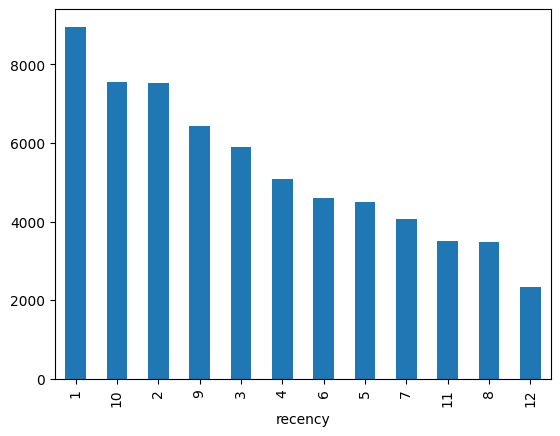

In [13]:
mem['recency'].value_counts().plot(kind='bar')

<Axes: xlabel='total_amount', ylabel='Count'>

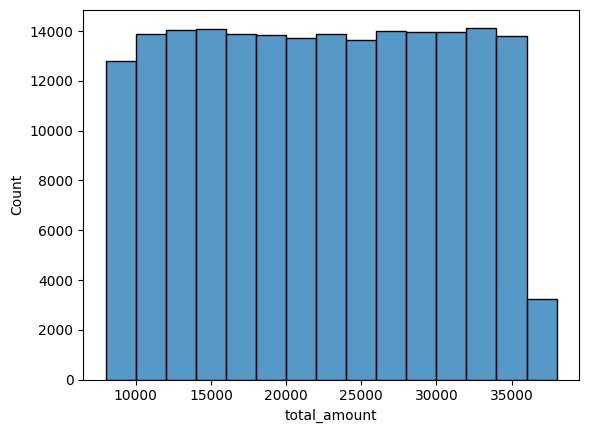

In [14]:
sns.histplot(tran['total_amount'], bins=15)

# 분포를 볼 수 있다. 

In [15]:
mem.groupby('recency')['conversion'].describe()


,count,mean,std,min,25%,50%,75%,max
recency,,,,,,,,
1,8952.0,0.193029,0.394698,0.0,0.0,0.0,0.0,1.0
2,7537.0,0.177790,0.382361,0.0,0.0,0.0,0.0,1.0
3,5904.0,0.166328,0.372406,0.0,0.0,0.0,0.0,1.0
4,5077.0,0.148907,0.356032,0.0,0.0,0.0,0.0,1.0
5,4510.0,0.142350,0.349448,0.0,0.0,0.0,0.0,1.0
6,4605.0,0.140717,0.347767,0.0,0.0,0.0,0.0,1.0
7,4078.0,0.133889,0.340575,0.0,0.0,0.0,0.0,1.0
8,3495.0,0.127897,0.334023,0.0,0.0,0.0,0.0,1.0
9,6441.0,0.113957,0.317784,0.0,0.0,0.0,0.0,1.0


결론 : recency 가 짧을수록 프로모션 성공률이 높다. 

In [16]:
mem.groupby('is_referral')['conversion'].value_counts()

is_referral  conversion
0            0             26343
             1              5513
1            0             28263
             1              3881
Name: count, dtype: int64

In [17]:
mem.groupby('is_referral')['conversion'].describe()

,count,mean,std,min,25%,50%,75%,max
is_referral,,,,,,,,
0,31856.0,0.173060,0.378305,0.0,0.0,0.0,0.0,1.0
1,32144.0,0.120738,0.325828,0.0,0.0,0.0,0.0,1.0


In [18]:
mem.groupby('channel')['conversion'].value_counts()

channel       conversion
Multichannel  0              6429
              1              1333
Phone         0             24458
              1              3563
Web           0             23719
              1              4498
Name: count, dtype: int64

In [19]:
mem.groupby('channel')['conversion'].describe()

,count,mean,std,min,25%,50%,75%,max
channel,,,,,,,,
Multichannel,7762.0,0.171734,0.377173,0.0,0.0,0.0,0.0,1.0
Phone,28021.0,0.127155,0.333152,0.0,0.0,0.0,0.0,1.0
Web,28217.0,0.159407,0.366062,0.0,0.0,0.0,0.0,1.0


In [ ]:
tran.head(20)

tran 데이터 통해, 한명의 고객의 구매 이력을 확인해야 함. 

In [20]:
# 데이터프레임 병합
# 여기서는 'id'가 공통된 키라고 가정합니다. 실제로 사용하는 키 이름을 확인해야 합니다.
data = pd.merge(tran, mem, on='id', how='inner')
data

,id,num_item,total_amount,recency,zip_code,is_referral,channel,conversion
0,906145,5,34000,10,Surburban,0,Phone,0
1,906145,1,27000,10,Surburban,0,Phone,0
2,906145,4,33000,10,Surburban,0,Phone,0
3,184478,4,29000,6,Rural,1,Web,0
4,394235,4,33000,7,Surburban,1,Web,0
...,...,...,...,...,...,...,...,...
196831,536246,5,24000,9,Urban,0,Phone,1
196832,927617,5,26000,10,Surburban,0,Web,1
196833,927617,3,22000,10,Surburban,0,Web,1
196834,927617,3,18000,10,Surburban,0,Web,1


In [21]:
data.head(20)

,id,num_item,total_amount,recency,zip_code,is_referral,channel,conversion
0,906145,5,34000,10,Surburban,0,Phone,0
1,906145,1,27000,10,Surburban,0,Phone,0
2,906145,4,33000,10,Surburban,0,Phone,0
3,184478,4,29000,6,Rural,1,Web,0
4,394235,4,33000,7,Surburban,1,Web,0
5,394235,4,8000,7,Surburban,1,Web,0
6,130152,2,11000,9,Rural,1,Web,0
7,130152,1,22000,9,Rural,1,Web,0
8,130152,1,23000,9,Rural,1,Web,0
9,130152,3,27000,9,Rural,1,Web,0


In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196836 entries, 0 to 196835
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            196836 non-null  int64 
 1   num_item      196836 non-null  int64 
 2   total_amount  196836 non-null  int64 
 3   recency       196836 non-null  int64 
 4   zip_code      196836 non-null  object
 5   is_referral   196836 non-null  int64 
 6   channel       196836 non-null  object
 7   conversion    196836 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 12.0+ MB


In [23]:
data['channel'].value_counts()

channel
Web             86934
Phone           86121
Multichannel    23781
Name: count, dtype: int64

In [24]:
def em1num(x):
    if x == "Web":
        return 0
    elif x == "Phone":
        return 1
    elif x == "Multichannel":
        return 2

In [25]:
data['channel'] = data['channel'].apply(em1num)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196836 entries, 0 to 196835
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            196836 non-null  int64 
 1   num_item      196836 non-null  int64 
 2   total_amount  196836 non-null  int64 
 3   recency       196836 non-null  int64 
 4   zip_code      196836 non-null  object
 5   is_referral   196836 non-null  int64 
 6   channel       196836 non-null  int64 
 7   conversion    196836 non-null  int64 
dtypes: int64(7), object(1)
memory usage: 12.0+ MB


In [26]:
data['zip_code'].value_counts()

zip_code
Surburban    88300
Urban        78801
Rural        29735
Name: count, dtype: int64

In [27]:
def em2num(x):
    if x == "Surburban":
        return 0
    elif x == "Urban":
        return 1
    elif x == "Rural":
        return 2

In [28]:
data['zip_code'] = data['zip_code'].apply(em2num)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196836 entries, 0 to 196835
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype
---  ------        --------------   -----
 0   id            196836 non-null  int64
 1   num_item      196836 non-null  int64
 2   total_amount  196836 non-null  int64
 3   recency       196836 non-null  int64
 4   zip_code      196836 non-null  int64
 5   is_referral   196836 non-null  int64
 6   channel       196836 non-null  int64
 7   conversion    196836 non-null  int64
dtypes: int64(8)
memory usage: 12.0 MB


In [29]:
# 그룹화하여 빈도 확인
result = data[['conversion', 'total_amount']].groupby('conversion').value_counts()
print(result)


conversion  total_amount
0           26000           6007
            33000           5998
            29000           5997
            15000           5987
            32000           5980
            13000           5969
            23000           5929
            31000           5928
            8000            5881
            21000           5875
            12000           5872
            28000           5864
            10000           5861
            19000           5857
            17000           5853
            30000           5850
            11000           5848
            14000           5843
            16000           5843
            35000           5818
            27000           5815
            25000           5787
            22000           5770
            9000            5765
            18000           5763
            34000           5736
            20000           5710
            24000           5692
1           34000           1136
            9000  

In [30]:
data

,id,num_item,total_amount,recency,zip_code,is_referral,channel,conversion
0,906145,5,34000,10,0,0,1,0
1,906145,1,27000,10,0,0,1,0
2,906145,4,33000,10,0,0,1,0
3,184478,4,29000,6,2,1,0,0
4,394235,4,33000,7,0,1,0,0
...,...,...,...,...,...,...,...,...
196831,536246,5,24000,9,1,0,1,1
196832,927617,5,26000,10,0,0,0,1
196833,927617,3,22000,10,0,0,0,1
196834,927617,3,18000,10,0,0,0,1


# ---------------------------------------------------------------------

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

In [32]:
X = data.drop('conversion', axis = 1)
y = data['conversion']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 100 )

In [33]:
dtc = DecisionTreeClassifier(max_depth= 2, random_state=7)
dtc.fit(X_train, y_train)
pred = dtc.predict(X_test)
print("accuracy_score", accuracy_score(y_test, pred))
print(classification_report(y_test, pred))

accuracy_score 0.8751418265567052
              precision    recall  f1-score   support

           0       0.87      1.00      0.93     49230
           1       1.00      0.25      0.40      9821

    accuracy                           0.88     59051
   macro avg       0.93      0.62      0.66     59051
weighted avg       0.89      0.88      0.84     59051



In [34]:
for i in range(1, 30):
    dtc = DecisionTreeClassifier(max_depth = i, random_state = 8)
    dtc.fit(X_train, y_train)
    pred = dtc.predict(X_test)
    print(i, accuracy_score(y_test, pred))
    print(i, classification_report(y_test, pred))

1 0.8612385903710352
1               precision    recall  f1-score   support

           0       0.86      1.00      0.92     49230
           1       1.00      0.17      0.28      9821

    accuracy                           0.86     59051
   macro avg       0.93      0.58      0.60     59051
weighted avg       0.88      0.86      0.82     59051

2 0.8751418265567052
2               precision    recall  f1-score   support

           0       0.87      1.00      0.93     49230
           1       1.00      0.25      0.40      9821

    accuracy                           0.88     59051
   macro avg       0.93      0.62      0.66     59051
weighted avg       0.89      0.88      0.84     59051

3 0.8751418265567052
3               precision    recall  f1-score   support

           0       0.87      1.00      0.93     49230
           1       1.00      0.25      0.40      9821

    accuracy                           0.88     59051
   macro avg       0.93      0.62      0.66     59051
weigh

25 0.8761070938680124
25               precision    recall  f1-score   support

           0       0.90      0.96      0.93     49230
           1       0.69      0.46      0.55      9821

    accuracy                           0.88     59051
   macro avg       0.80      0.71      0.74     59051
weighted avg       0.86      0.88      0.87     59051

26 0.8755313203840748
26               precision    recall  f1-score   support

           0       0.90      0.96      0.93     49230
           1       0.68      0.47      0.56      9821

    accuracy                           0.88     59051
   macro avg       0.79      0.71      0.74     59051
weighted avg       0.86      0.88      0.87     59051

27 0.8755313203840748
27               precision    recall  f1-score   support

           0       0.90      0.95      0.93     49230
           1       0.67      0.49      0.57      9821

    accuracy                           0.88     59051
   macro avg       0.79      0.72      0.75     59051

# ---------------------------------------------------------------------

# 배깅 모델
* 부트스트랩
* 독립된 분류기(모델)
* 투표